<a href="https://colab.research.google.com/github/OlhaZahrebelna/Bank-Loan-Analysis-Project/blob/main/Project_bank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install psycopg2-binary


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 24.7 MB/s eta 0:00:00


In [ ]:
!pip install python-dotenv


In [ ]:
import datetime
import os

from dotenv import load_dotenv
import numpy as np
import pandas as pd
import psycopg2
from scipy.stats import pearsonr
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [ ]:
load_dotenv("/content/project.env")

True

In [ ]:
host = os.getenv("HOST")
port = os.getenv("PORT")
dbname = os.getenv("DBNAME")
user = os.getenv("USER")
password = os.getenv("PASSWORD")

In [ ]:
try:
    conn = psycopg2.connect(
        host=host,
        port=port,
        dbname=dbname,
        user=user,
        password=password
    )
    print("Connection is successful!")
except Exception as e:
    print(f"Connection error: {e}")

Connection is successful!


In [ ]:
first_five_row = pd.read_sql("SELECT * FROM credit_fs LIMIT 5;", conn)

In [ ]:
first_five_row.head()

,UID,ALL_AgeOfOldestAccount,ALL_AgeOfYoungestAccount,ALL_Count,ALL_CountActive,ALL_CountClosedLast12Months,ALL_CountDefaultAccounts,ALL_CountOpenedLast12Months,ALL_CountSettled,ALL_MeanAccountAge,ALL_SumCurrentOutstandingBal,ALL_SumCurrentOutstandingBalExcMtg,ALL_TimeSinceMostRecentDefault,ALL_WorstPaymentStatusActiveAccounts
0,216009,227,12,14,11,0,3,0,3,71.36,9292,9292,-1,7
1,217537,49,10,7,6,1,3,1,1,29.33,4592,4592,-1,7
2,221803,134,0,12,11,0,3,5,1,32.33,2737,2737,-1,7
3,222260,227,2,39,12,0,2,2,27,41.56,9229,9229,-1,7
4,222848,132,2,99,11,8,0,9,88,43.34,15443,15443,-1,0


**check for empty values credit_fs, loan_applications**

In [ ]:
credit_fs = pd.read_sql("SELECT * FROM credit_fs;", conn)
credit_fs.isnull().sum()

,0
UID,0
ALL_AgeOfOldestAccount,0
ALL_AgeOfYoungestAccount,0
ALL_Count,0
ALL_CountActive,0
ALL_CountClosedLast12Months,0
ALL_CountDefaultAccounts,0
ALL_CountOpenedLast12Months,0
ALL_CountSettled,0
ALL_MeanAccountAge,0


In [ ]:
l_apps = pd.read_sql("SELECT * FROM l_apps;", conn)
l_apps.isnull().sum()

,0
UID,0
ApplicationDate,0
Amount,0
Term,0
EmploymentType,0
LoanPurpose,0
Success,0


# How is the loan amount distributed across different types of employment?

**Sum of data on different employment types for successful applications**

In [ ]:
sum_loan_by_empl_type = pd.read_sql("""
    SELECT
    "EmploymentType" AS employment_type,
    COUNT(*) AS loan_count,
    ROUND(AVG("Amount"), 2) AS average_loan_amount,
    SUM("Amount") AS total_loan_amount,
    MAX("Amount") AS max_loan_amount,
    MIN("Amount") AS min_loan_amount
FROM
    l_apps
WHERE
    "Success" = 1
GROUP BY
    "EmploymentType"
ORDER BY
    total_loan_amount DESC
""", conn)

sum_loan_by_empl_type


,employment_type,loan_count,average_loan_amount,total_loan_amount,max_loan_amount,min_loan_amount
0,Employed - full time,665,6119.29,4069325,20000,500
1,Employed - part time,69,4614.57,318405,10000,1000
2,Self employed,20,7285.00,145700,15000,1500
3,Retired,16,5906.25,94500,15000,2000


**Sum of data on different types of employment for unsuccessful applications**

In [ ]:
sum_non_loan_by_empl_type = pd.read_sql("""
    SELECT
    "EmploymentType" AS employment_type,
    COUNT(*) AS non_loan_count,
    ROUND(AVG("Amount"), 2) AS average_non_loan_amount,
    SUM("Amount") AS total_non_loan_amount,
    MAX("Amount") AS max_non_loan_amount,
    MIN("Amount") AS min_non_loan_amount
FROM
    l_apps
WHERE
    "Success" = 0
GROUP BY
    "EmploymentType"
ORDER BY
    total_non_loan_amount DESC
""", conn)

sum_non_loan_by_empl_type


,employment_type,non_loan_count,average_non_loan_amount,total_non_loan_amount,max_non_loan_amount,min_non_loan_amount
0,Employed - full time,5879,8066.94,47425512,20000,500
1,Employed - part time,404,6850.50,2767601,20000,500
2,Self employed,298,8750.87,2607758,20000,500
3,Retired,108,6793.52,733700,20000,1000


The data shows that full-time employees submit more applications than individuals with other types of employment. However, a significant portion of applications were rejected. When comparing the average loan amounts, clients who had their loans approved generally required less money than those whose applications were rejected.

**Percentage of rejected applications**

In [ ]:
percentage_of_rejected_applications = pd.read_sql("""
    SELECT
    ROUND(
        ROUND(
            SUM(CASE WHEN "Success" = 0 THEN 1 ELSE 0 END)::NUMERIC /
            COUNT(*)::NUMERIC,
            3
        ) * 100,
        1
    ) AS rejection_percentage
FROM
    l_apps;
""", conn)

percentage_of_rejected_applications


,rejection_percentage
0,89.7


According to the analysis, 89.7% of the applications were rejected. This indicates a high percentage of negative decisions, which may require further analysis of the reasons for rejection and potential improvements in the application assessment process.

# What is the most common purpose of the loan among the applications?

In [ ]:
loan_purpose_count = pd.read_sql("""
    SELECT
       COUNT("LoanPurpose") AS loan_purpose_count,
       "LoanPurpose" AS loan_purpose
    FROM public.l_apps
    GROUP BY "LoanPurpose"
    ORDER BY COUNT("LoanPurpose") DESC;
""", conn)

loan_purpose_count.head(10)


,loan_purpose_count,loan_purpose
0,978,Car
1,581,Consolidation
2,373,car
3,357,Debt consolidation
4,186,Other
5,186,Home improvement
6,175,Home improvements
7,137,consolidation
8,133,debt consolidation
9,103,Debt Consolidation


We can see that the data has some inaccuracies, so I processed it in PostgreSQL. Specifically, I tried to group it by the most common loan purposes. Additionally, I want to have two columns: one with data for all applications and another one for data on the approved applications only.

In [ ]:
loan_purpose_count = pd.read_sql("""
WITH normalized_data AS (
    SELECT
        CASE
            WHEN LOWER("LoanPurpose") LIKE '%car%' THEN 'Car'
            WHEN LOWER("LoanPurpose") LIKE '%home improvement%' THEN 'Home Improvement'
            WHEN LOWER("LoanPurpose") LIKE '%debt%' THEN 'Debt Consolidation'
            WHEN LOWER("LoanPurpose") LIKE '%consolida%' THEN 'Consolidation'
            WHEN LOWER("LoanPurpose") LIKE '%wedding%' THEN 'Wedding'
            WHEN LOWER("LoanPurpose") LIKE '%holiday%' THEN 'Holiday'
            WHEN LOWER("LoanPurpose") LIKE '%home%' THEN 'Home'
            WHEN LOWER("LoanPurpose") LIKE '%vet%' THEN 'Vet'
            WHEN LOWER("LoanPurpose") LIKE '%motor%' THEN 'Motorbike'
            WHEN LOWER("LoanPurpose") LIKE '%furniture%' THEN 'Furniture'
            WHEN LOWER("LoanPurpose") LIKE '%house%' THEN 'House'
            ELSE 'Other'
        END AS normalized_loan_purpose,
        "Success"
    FROM l_apps
)
SELECT
    normalized_loan_purpose,
    COUNT(*) AS total_loan_count,
    SUM(CASE WHEN "Success" = 1 THEN 1 ELSE 0 END) AS approved_loan_count
FROM normalized_data
GROUP BY normalized_loan_purpose
ORDER BY total_loan_count DESC;
""", conn)

loan_purpose_count


,normalized_loan_purpose,total_loan_count,approved_loan_count
0,Car,2460,275
1,Other,1655,172
2,Debt Consolidation,1088,104
3,Consolidation,857,63
4,Home Improvement,629,72
5,House,230,26
6,Home,207,23
7,Vet,92,9
8,Furniture,70,7
9,Holiday,66,9


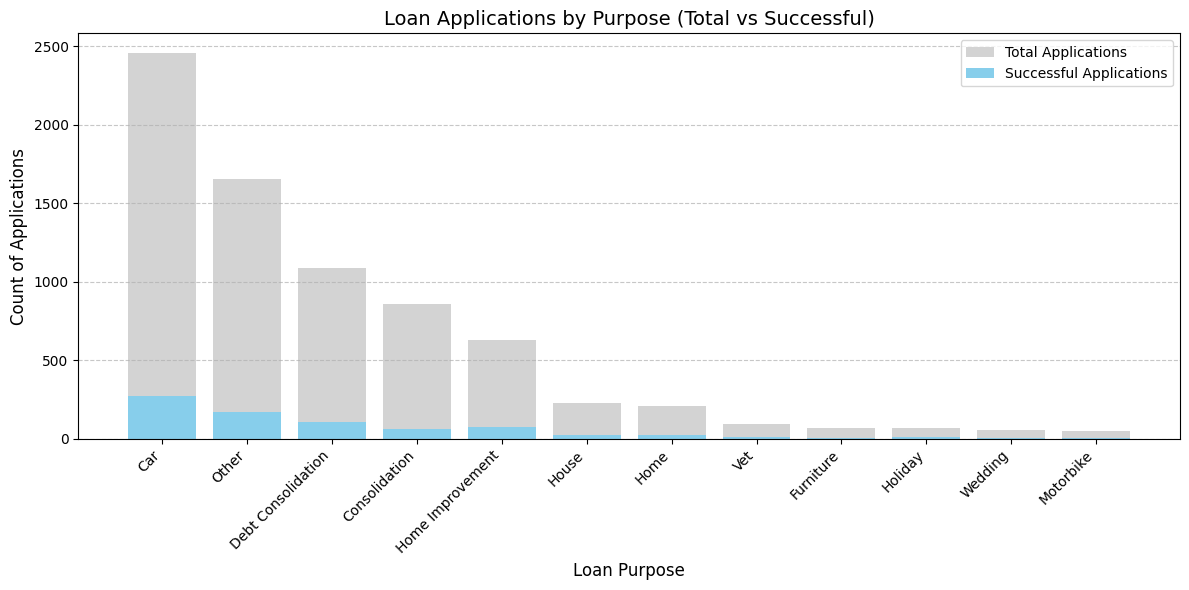

In [ ]:
plt.figure(figsize=(12, 6))

plt.bar(loan_purpose_count['normalized_loan_purpose'], loan_purpose_count['total_loan_count'], label='Total Applications', color='lightgray')
plt.bar(loan_purpose_count['normalized_loan_purpose'], loan_purpose_count['approved_loan_count'], label='Successful Applications', color='skyblue')

plt.xticks(loan_purpose_count['normalized_loan_purpose'], rotation=45, ha='right')
plt.xlabel('Loan Purpose', fontsize=12)
plt.ylabel('Count of Applications', fontsize=12)
plt.title('Loan Applications by Purpose (Total vs Successful)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()


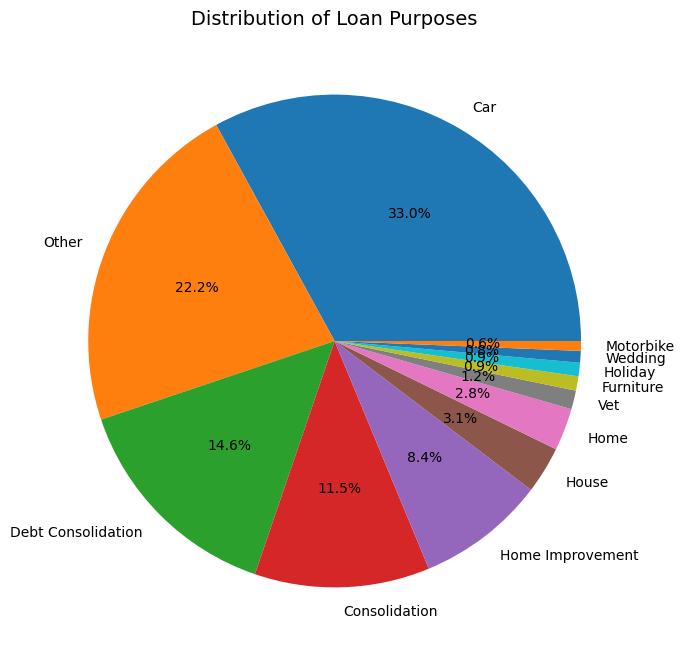

In [ ]:
plt.figure(figsize=(8, 8))

plt.pie(
    loan_purpose_count['total_loan_count'],
    labels=loan_purpose_count['normalized_loan_purpose'],
    autopct='%1.1f%%'
)

plt.title('Distribution of Loan Purposes', fontsize=14);


The highest number of applications was submitted for car loans (**Car**), with 2460 applications and 275 approved. This indicates a high demand for auto loans among applicants.
**Other purposes**, including various needs, take second place with 1655 applications and 172 approved. This suggests a significant demand for loans for non-specific purposes.
**Debt Consolidation and Consolidation** rank third and fourth in terms of the number of applications (1088 and 857, respectively), but they have a noticeably lower approval rate, which may indicate greater difficulty in decision-making for these types of loans.
**Home Improvement** loans (629 applications) are a popular purpose, but the number of approved loans is not as high, which may suggest stricter approval requirements.
Loans for **house construction **(House) and home-related purposes (Home) have considerably fewer applications (230 and 207), with only a small proportion being approved.
Loans for vet bills (**Vet**), furniture (**Furniture**), holidays (**Holiday**), weddings (**Wedding**), and motorbikes (**Motorbike**) have the lowest number of applications, indicating that these purposes are less common among applicants.

# Does the success of the application depend on the type of employment?

In [ ]:
loan_success_by_employment_type = pd.read_sql("""
    WITH employment_data AS (
        SELECT
            "EmploymentType",
            COUNT(CASE WHEN "Success" = 1 THEN 1 END) AS success_count,
            COUNT(*) AS total_count
        FROM
            l_apps
        GROUP BY
            "EmploymentType"
    )
    SELECT
        "EmploymentType",
        ROUND((success_count::NUMERIC / total_count) * 100, 2) AS success_rate_by_employment
    FROM
        employment_data
    ORDER BY
        success_rate_by_employment DESC;
""", conn)

loan_success_by_employment_type

,EmploymentType,success_rate_by_employment
0,Employed - part time,14.59
1,Retired,12.90
2,Employed - full time,10.16
3,Self employed,6.29


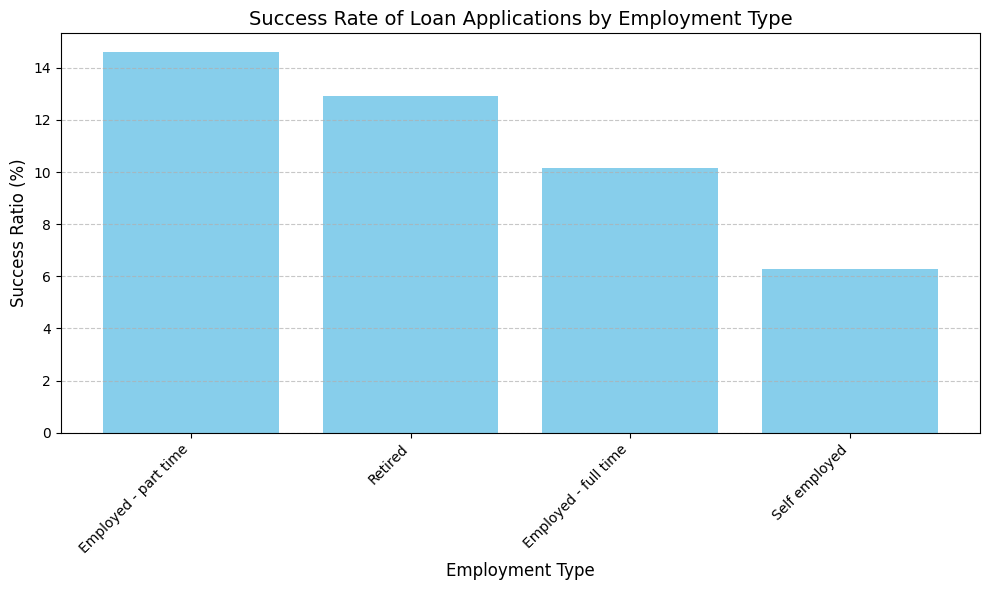

In [ ]:
plt.figure(figsize=(10, 6))

plt.bar(loan_success_by_employment_type['EmploymentType'], loan_success_by_employment_type['success_rate_by_employment'], color='skyblue')

plt.xlabel('Employment Type', fontsize=12)
plt.ylabel('Success Ratio (%)', fontsize=12)
plt.title('Success Rate of Loan Applications by Employment Type', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()


It is interesting that the data shows that employees working part-time receive a higher proportion of positive responses compared to retirees and full-time workers.

# How does the loan term affect the probability of success?

In [ ]:
loan_success_by_term = pd.read_sql("""
    WITH loan_term_data AS (
        SELECT
            CONCAT("Term", ' months') AS loan_term_label,
            COUNT(CASE WHEN "Success" = 1 THEN 1 END) AS success_count,
            COUNT(*) AS total_count
        FROM
            l_apps
        GROUP BY
            CONCAT("Term", ' months')
    )
    SELECT
        loan_term_label,
        ROUND((success_count::DOUBLE PRECISION / total_count) * 100) AS success_rate_by_term
    FROM
        loan_term_data
    ORDER BY
        success_rate_by_term DESC;
""", conn)

loan_success_by_term

,loan_term_label,success_rate_by_term
0,42 months,41.0
1,30 months,19.0
2,48 months,13.0
3,36 months,13.0
4,18 months,12.0
5,24 months,10.0
6,12 months,7.0
7,60 months,7.0
8,54 months,6.0


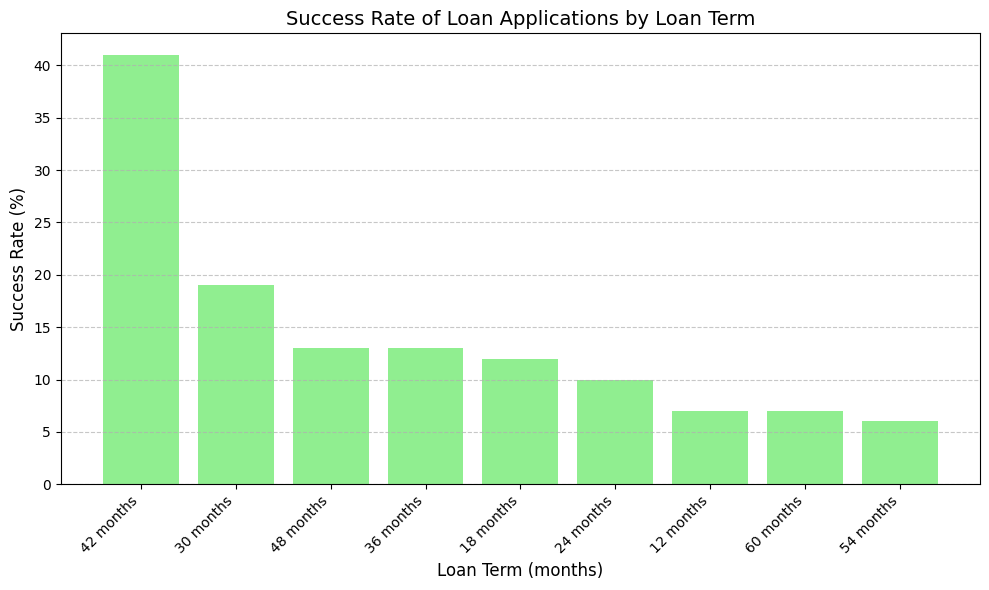

In [ ]:
plt.figure(figsize=(10, 6))

plt.bar(loan_success_by_term['loan_term_label'], loan_success_by_term['success_rate_by_term'], color='lightgreen')

plt.xlabel('Loan Term (months)', fontsize=12)
plt.ylabel('Success Rate (%)', fontsize=12)
plt.title('Success Rate of Loan Applications by Loan Term', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()


We can observe that the highest approval rate for loans is seen for the 42-month term. This is quite predictable, as most of the loans are likely for car purchases, and this term aligns with the typical warranty period for vehicles. It is reasonable to assume that many borrowers prefer this term because it matches the vehicle’s warranty period, which is a common practice among both borrowers and lenders. Additionally, loans with shorter terms (12–24 months) tend to have significantly lower success rates.

# What is the average age of the oldest account among successful applications?

In [ ]:
avg_old_loan_suc = pd.read_sql(
    """SELECT round(AVG("ALL_AgeOfOldestAccount")) AS avg_age_of_oldest_account
    FROM credit_fs AS c
    JOIN l_apps AS l ON c."UID" = l."UID"
    WHERE l."Success" = 1;
    """, conn
)

avg_age_of_oldest_account = avg_old_loan_suc['avg_age_of_oldest_account'][0]
avg_age_of_oldest_account

184.0

We can see that the average age of the account among successful applications is quite high — 15 years. This may indicate that people who receive positive responses have long-term and stable financial relationships with banks or credit institutions. This result could be valuable for lenders, as it suggests potentially reliable customers with a good credit history.

# Does the number of open accounts in the last 12 months affect the probability of success of the application?

In [ ]:
impact_on_success_open_count = pd.read_sql("""
SELECT
    ROUND(AVG(c."ALL_CountOpenedLast12Months")::NUMERIC, 2) AS avg_opened_accounts,
    ROUND(
        AVG(CASE
            WHEN l."Success" = 1 THEN c."ALL_CountOpenedLast12Months"
        END)::NUMERIC,
        2
    ) AS avg_opened_accounts_success
FROM
    l_apps AS l
JOIN
    credit_fs AS c
ON
    c."UID" = l."UID";
""", conn)

impact_on_success_open_count

,avg_opened_accounts,avg_opened_accounts_success
0,2.44,1.82


The overall average number of accounts opened in the last 12 months is 2.45. However, the average number of accounts opened for successful applications is 1.81. This suggests that there is a negative correlation between the number of accounts opened and the likelihood of success: the fewer accounts opened, the higher the chance of the application being approved. This may be due to the fact that lenders are more likely to approve applications from individuals who already have a stable financial situation and do not open many new accounts in a short period.

# Is there a relationship between the amount of balances on all accounts and the success of the application?

In [ ]:
dependency_between_balance_and_success = pd.read_sql("""
SELECT
    ROUND(AVG(CASE WHEN l."Success" = 1 THEN c."ALL_SumCurrentOutstandingBal" END), 2) AS avg_balance_success,
    ROUND(AVG(CASE WHEN l."Success" = 0 THEN c."ALL_SumCurrentOutstandingBal" END), 2) AS avg_balance_failure,
    ROUND(AVG(CASE WHEN l."Success" = 1 THEN c."ALL_SumCurrentOutstandingBalExcMtg" END), 2) AS avg_balance_exc_mtg_success,
    ROUND(AVG(CASE WHEN l."Success" = 0 THEN c."ALL_SumCurrentOutstandingBalExcMtg" END), 2) AS avg_balance_exc_mtg_failure
FROM
    l_apps AS l
JOIN
    credit_fs AS c
ON
    c."UID" = l."UID";
""", conn)

dependency_between_balance_and_success

,avg_balance_success,avg_balance_failure,avg_balance_exc_mtg_success,avg_balance_exc_mtg_failure
0,66749.57,53809.63,9659.96,13367.74


Total Balance: The average current balance for successful applications (66,749.57) is higher than for unsuccessful ones (53,809.63). This suggests that clients with higher total balances have a greater chance of having their application approved. The relationship is positive: the higher the balance, the higher the chances of success. A higher total balance may indicate the client's financial stability, which the bank likely considers when making decisions.

Balance Excluding Mortgage: The average balance excluding mortgage for successful applications (9,659.96) is lower than for unsuccessful ones (13,367.74). This is somewhat surprising, as clients with larger non-mortgage assets would typically have higher chances of approval. However, this could be due to the bank placing more emphasis on mortgage-related balances or other financial indicators, such as payment history, instead of focusing solely on non-mortgage balances.

# Which payment status is most common among active accounts?

In [ ]:
status_explanation = {
    '0': 'No overdue payments',
    '1': '1-30 days overdue',
    '2': '31-60 days overdue',
    '3': '61-90 days overdue',
    '4': '91-120 days overdue',
    '5': 'More than 120 days overdue',
    '6': 'Defaulted or settled account',
    '-1': 'Status not available or undefined',
    '7': 'Account under legal proceedings or collection'
}

codes_active_count = pd.read_sql("""
SELECT "ALL_WorstPaymentStatusActiveAccounts",
       count("ALL_CountActive")
FROM credit_fs
GROUP BY "ALL_WorstPaymentStatusActiveAccounts"
ORDER BY count("ALL_CountActive") DESC;
""", conn)

codes_active_count['Status_Explanation'] = codes_active_count['ALL_WorstPaymentStatusActiveAccounts'].apply(
    lambda x: status_explanation.get(str(x), 'Unknown status')
)

display(codes_active_count)


,ALL_WorstPaymentStatusActiveAccounts,count,Status_Explanation
0,0,5822,No overdue payments
1,7,2448,Account under legal proceedings or collection
2,1,202,1-30 days overdue
3,-1,116,Status not available or undefined
4,2,85,31-60 days overdue
5,6,69,Defaulted or settled account
6,3,48,61-90 days overdue
7,4,31,91-120 days overdue
8,5,26,More than 120 days overdue


**No overdue payments** – The largest number of active accounts (5822), indicating that the majority of active clients are not experiencing overdue payments.
**Account under legal proceedings or collection** – Second place with 2448 accounts, suggesting a significant portion of clients are in a difficult financial situation with legal proceedings or collections.
**1-30 days overdue** – A small number of accounts (202), indicating a low percentage of clients with early overdue payments.
**Status not available or undefined** – 116 accounts, possibly due to insufficient data or incomplete records.
**31-60 days overdue** – Only 85 accounts, showing that a relatively small proportion of accounts are overdue by this period.

# How does the number of accounts with defaults affect the probability of obtaining a loan?


In [ ]:
count_with_default = pd.read_sql("""
SELECT c."ALL_CountDefaultAccounts" AS default_accounts_count,
       count(c."ALL_CountDefaultAccounts") AS total_applications,
       ROUND(SUM(CASE WHEN "Success" = 1 THEN 1 ELSE 0 END)::NUMERIC / COUNT(*) * 100, 2) AS success_rate
FROM credit_fs AS c
JOIN l_apps AS l ON c."UID" = l."UID"
GROUP BY 1
ORDER BY success_rate DESC;
""", conn)

count_with_default.head()

,default_accounts_count,total_applications,success_rate
0,0,4802,13.81
1,1,725,8.97
2,2,441,5.67
3,4,248,2.02
4,3,317,1.89


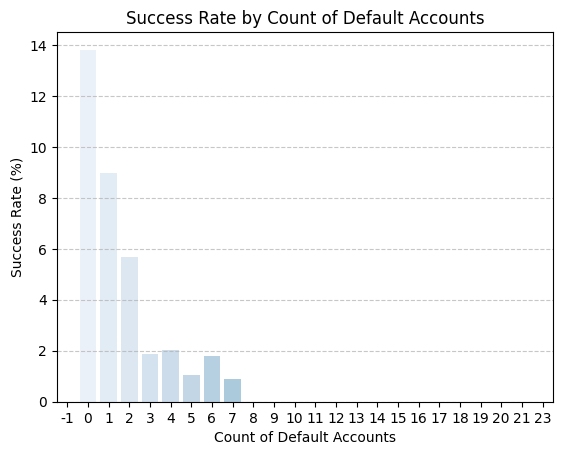

In [ ]:
sns.barplot(x='default_accounts_count', y='success_rate', data=count_with_default, palette='Blues')
plt.xlabel('Count of Default Accounts')
plt.ylabel('Success Rate (%)')
plt.title('Success Rate by Count of Default Accounts')
plt.grid(axis='y', linestyle='--', alpha=0.7);

In [ ]:
correlation, _ = pearsonr(count_with_default['default_accounts_count'], count_with_default['success_rate'])
print(f'Correlation: {correlation}')

Correlation: -0.5849177641176787


The correlation between the number of default accounts and the success rate of applications is -0.58, indicating a moderately strong negative correlation. The highest success rate is observed among applicants without default accounts. When the number of default accounts exceeds 8, the probability of a positive response significantly decreases. This suggests that a high number of default accounts signals financial instability to the bank. As the correlation indicates, with an increase in the number of default accounts, the chances of a successful application decrease.

# In what period of the year are applications most often submitted?

In [ ]:
appl_date = pd.read_sql("""
SELECT TO_CHAR("ApplicationDate", 'Month') AS month_name,
       EXTRACT(MONTH FROM "ApplicationDate") AS month_number,
       COUNT("ApplicationDate") AS countloan
FROM l_apps
GROUP BY month_name, month_number
ORDER BY month_number;
""", conn)

appl_date

,month_name,month_number,countloan
0,January,1.0,796
1,February,2.0,576
2,March,3.0,561
3,April,4.0,687
4,May,5.0,643
5,June,6.0,600
6,July,7.0,607
7,August,8.0,632
8,September,9.0,594
9,October,10.0,497


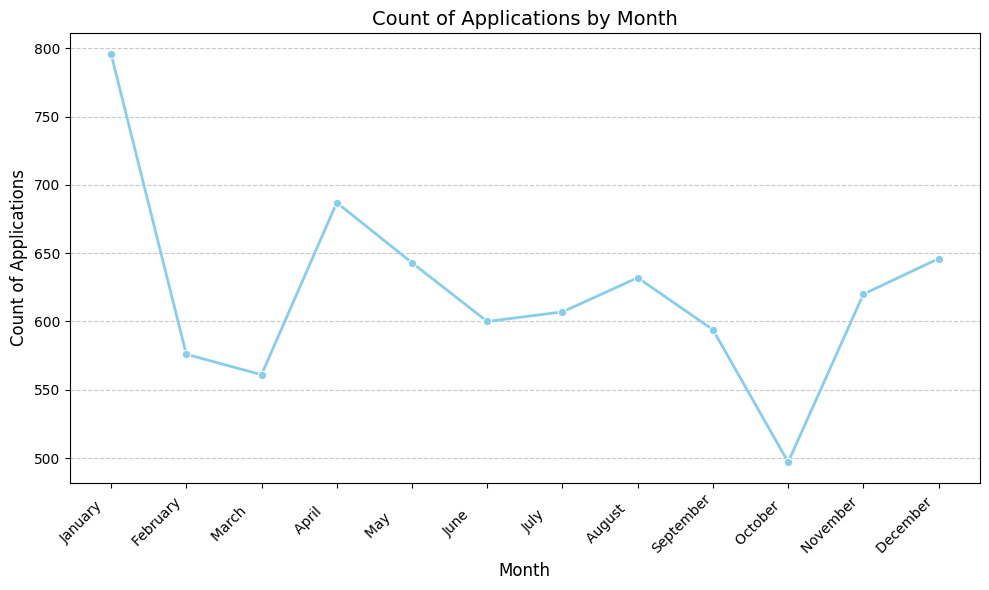

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    x='month_name',
    y='countloan',
    data=appl_date,
    marker='o',
    color='skyblue',
    linewidth=2
)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count of Applications', fontsize=12)
plt.title('Count of Applications by Month', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

The data shows that the highest number of loan applications occurs in January (796 applications), while the lowest number is observed in October (497 applications). This trend may be influenced by seasonal factors, such as post-holiday spending in January or decreased activity in the autumn months.

Additionally, there seems to be a slight cyclicality – minor peaks in applications approximately every four months. This could indicate a seasonal dependency in loan requests, potentially tied to customer needs during different times of the year (vacations, purchases, or other financial demands).

# Does the average loan amount vary by month and quarter?

In [ ]:
avg_sum_loan_by_month_and_quarter = pd.read_sql("""
WITH cte AS (
  SELECT TO_CHAR("ApplicationDate", 'Month') AS month_name,
         EXTRACT(MONTH FROM "ApplicationDate") AS month,
         ROUND(AVG("Amount"), 2) AS avg_amount
  FROM public.l_apps
  GROUP BY month_name, month
)
SELECT month_name,
       month,
       avg_amount,
       ROUND(AVG(avg_amount) OVER(PARTITION BY EXTRACT(QUARTER FROM TO_DATE(month::text, 'MM'))), 2) AS avg_quarter_amount
FROM cte
ORDER BY month;""", conn)

avg_sum_loan_by_month_and_quarter

,month_name,month,avg_amount,avg_quarter_amount
0,January,1.0,7700.87,7551.01
1,February,2.0,7490.47,7551.01
2,March,3.0,7461.70,7551.01
3,April,4.0,6935.47,7569.61
4,May,5.0,7733.70,7569.61
5,June,6.0,8039.67,7569.61
6,July,7.0,8196.86,8115.46
7,August,8.0,7939.00,8115.46
8,September,9.0,8210.51,8115.46
9,October,10.0,8203.16,8015.36


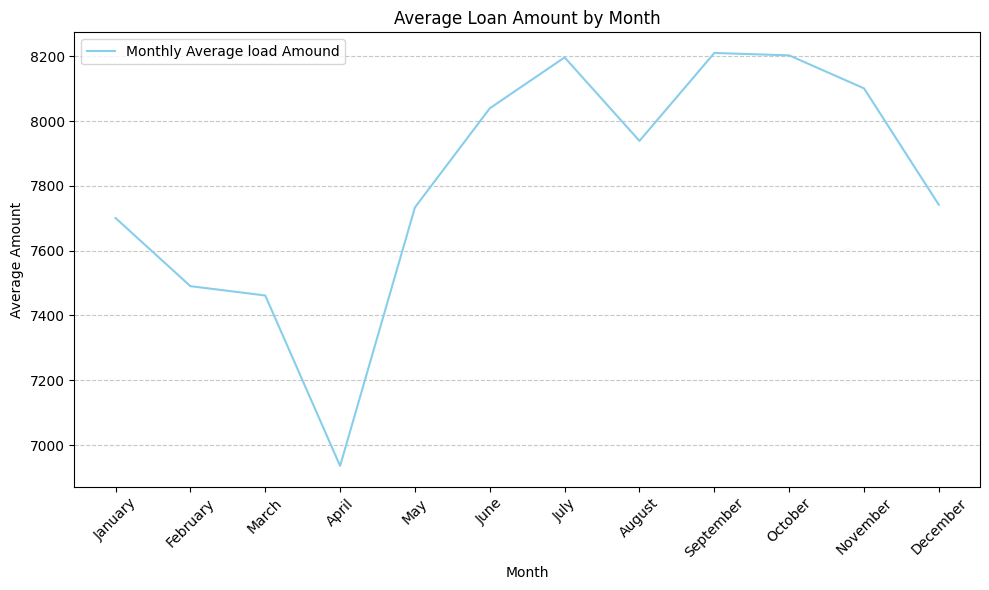

In [ ]:
avg_sum_loan_by_month_and_quarter.sort_values('month', inplace=True)

plt.figure(figsize=(10, 6))
sns.lineplot(
    x='month',
    y='avg_amount',
    data=avg_sum_loan_by_month_and_quarter,
    label='Monthly Average load Amound',
    color='skyblue'
)


plt.xticks(
    ticks=range(1, 13),
    labels=[
        'January', 'February', 'March', 'April', 'May', 'June',
        'July', 'August', 'September', 'October', 'November', 'December'
    ],
    rotation=45
)
plt.xlabel('Month')
plt.ylabel('Average Amount')
plt.title('Average Loan Amount by Month')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

Interestingly, in April, we observe an increase in the number of applications, but the average loan amount is the lowest compared to other months. This may indicate a seasonal demand for smaller loan amounts in spring.

The average loan amounts are highest in the third and fourth quarters, likely due to summer vacation needs or pre-holiday spending towards the end of the year.

# What is the average loan term among submitted applications in each quarter?

In [ ]:
avg_term_loan_by_quarter = pd.read_sql("""
WITH atlbq AS (
    SELECT
        EXTRACT(QUARTER FROM "ApplicationDate") AS quarter,
        ROUND(AVG("Term"), 2) AS avg_term_quarter
    FROM
        l_apps
    GROUP BY
        EXTRACT(QUARTER FROM "ApplicationDate")
    ORDER BY
        quarter
)
SELECT
    CONCAT('Q', quarter) AS quarter_name,
    avg_term_quarter
FROM
    atlbq;""", conn)

avg_term_loan_by_quarter


,quarter_name,avg_term_quarter
0,Q1,41.48
1,Q2,42.41
2,Q3,43.28
3,Q4,42.14


The average loan term slightly varies across quarters but remains within a close range (41-43 days).
The third quarter (Q3) has the highest average loan term of 43.28 days, which might indicate longer-term loans being more popular during this period.
The first quarter (Q1) has the shortest average loan term (41.48 days), potentially reflecting a preference for shorter-term loans at the beginning of the year.

# Does the probability of application success change depending on the time of submission?

In [ ]:
probability_success_by_time = pd.read_sql("""
WITH psbt AS (
    SELECT
        TO_CHAR("ApplicationDate", 'Month') AS application_month,
        sum("Success") AS successful,
        count(*) - sum("Success") AS not_successful,
        EXTRACT(MONTH FROM "ApplicationDate") AS month_number
    FROM l_apps
    GROUP BY application_month, month_number
    ORDER BY month_number
)
SELECT
    application_month,
    ROUND(CAST(successful AS NUMERIC) / (successful + not_successful) * 100, 2) AS probability_success
FROM psbt
ORDER BY month_number;
""", conn)

probability_success_by_time

,application_month,probability_success
0,January,8.42
1,February,9.55
2,March,8.38
3,April,11.64
4,May,10.89
5,June,9.00
6,July,11.04
7,August,12.50
8,September,10.10
9,October,10.06


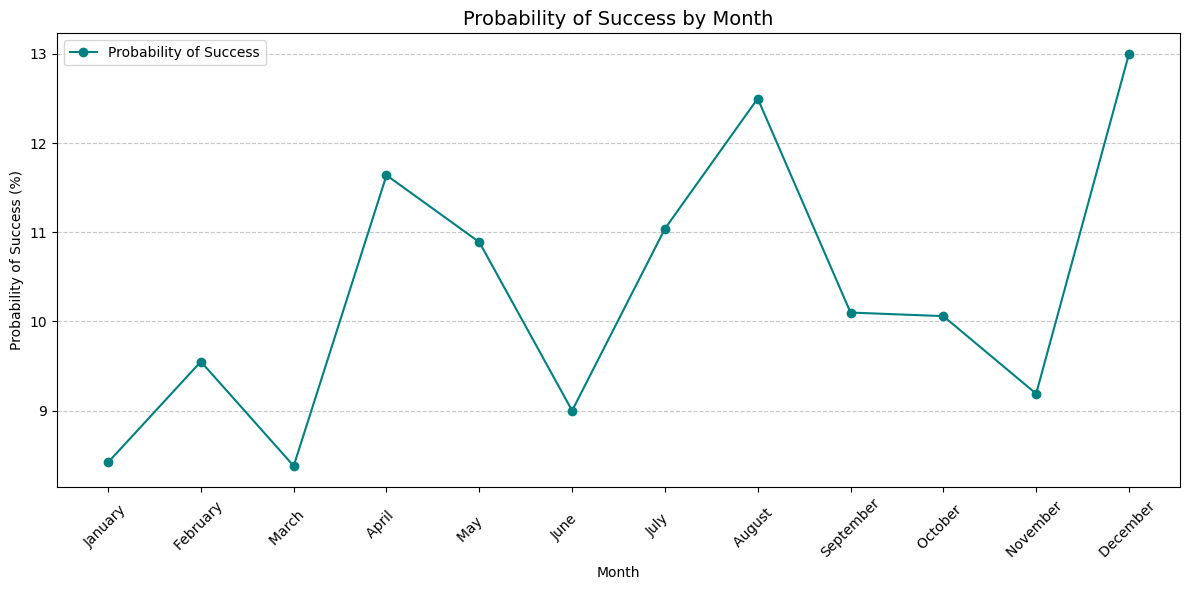

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(probability_success_by_time['application_month'], probability_success_by_time['probability_success'],
         marker='o', linestyle='-', color='teal', label='Probability of Success')

plt.xlabel('Month')
plt.ylabel('Probability of Success (%)')
plt.title('Probability of Success by Month', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend();

Highest probability in December: The high rate in December may be due to seasonal factors, such as bank specials or the need for loans before the holidays.
Low probability in January and March: This may indicate stricter application approval conditions or less creditworthiness of customers after holiday spending.

In [ ]:
successful_or_not_by_month = pd.read_sql("""SELECT
        extract(MONTH FROM "ApplicationDate") AS application_month,
        sum("Success") AS successful,
        count(*) - sum("Success") AS not_successful
    FROM l_apps
    GROUP BY 1
    ORDER BY 1""", conn)

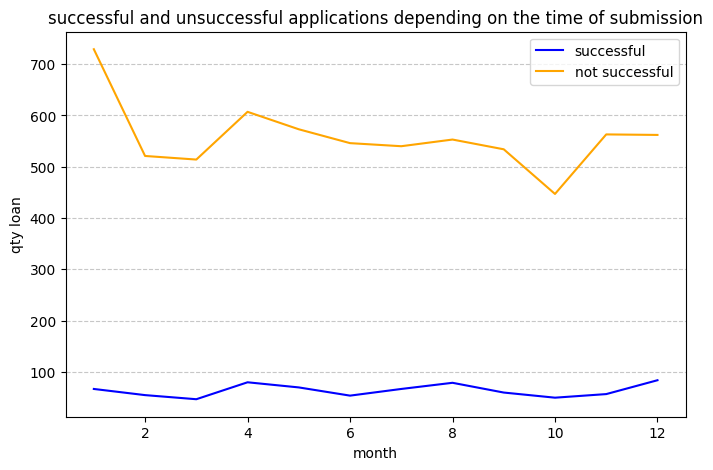

In [ ]:
x = successful_or_not_by_month['application_month']
y1 = successful_or_not_by_month['successful']
y2 = successful_or_not_by_month['not_successful']

plt.figure(figsize=(8, 5))
plt.plot(x, y1, label='successful', color='blue')
plt.plot(x, y2, label='not successful', color='orange')
plt.xlabel('month')
plt.ylabel('qty loan')
plt.title('successful and unsuccessful applications depending on the time of submission')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# What is the average purchase requisition amount for different lending purposes?

In [ ]:
avg_load_by_purpose = pd.read_sql("""
SELECT
    CASE
        WHEN LOWER("LoanPurpose") LIKE '%car%' THEN 'Car'
        WHEN LOWER("LoanPurpose") LIKE '%home improvement%' THEN 'Home Improvement'
        WHEN LOWER("LoanPurpose") LIKE '%debt%' THEN 'Debt Consolidation'
        WHEN LOWER("LoanPurpose") LIKE '%consolida%' THEN 'Consolidation'
        WHEN LOWER("LoanPurpose") LIKE '%wedding%' THEN 'Wedding'
        WHEN LOWER("LoanPurpose") LIKE '%holiday%' THEN 'Holiday'
        WHEN LOWER("LoanPurpose") LIKE '%home%' THEN 'Home'
        WHEN LOWER("LoanPurpose") LIKE '%vet%' THEN 'Vet'
        WHEN LOWER("LoanPurpose") LIKE '%motor%' THEN 'Motorbike'
        WHEN LOWER("LoanPurpose") LIKE '%furniture%' THEN 'Furniture'
        WHEN LOWER("LoanPurpose") LIKE '%house%' THEN 'House'
        ELSE 'Other'
    END AS normalized_purpose,
    AVG("Amount") AS avg_amount
FROM l_apps
GROUP BY normalized_purpose
ORDER BY avg_amount DESC;
""", conn)

In [ ]:
avg_load_by_purpose

,normalized_purpose,avg_amount
0,Wedding,8789.473684
1,Motorbike,8607.291667
2,Consolidation,8543.004667
3,Car,8502.039024
4,Debt Consolidation,8056.957721
5,Home Improvement,7577.346582
6,Home,7455.072464
7,Furniture,7414.285714
8,House,6666.086957
9,Other,6625.932326


# What is the average purchase requisition amount for different credit purposes by month?

This query allows you to:

See the average amount of loan applications for different purposes for each month.
Analyze the number of applications (demand) for each category of credit objectives in a particular month.

In [ ]:
avg_load_by_purpose_and_month = pd.read_sql("""SELECT extract(MONTH
               FROM "ApplicationDate") AS number_of_month,
       TO_CHAR("ApplicationDate", 'Month') AS application_month,
       CASE
           WHEN LOWER("LoanPurpose") LIKE '%car%' THEN 'Car'
           WHEN LOWER("LoanPurpose") LIKE '%home improvement%' THEN 'Home Improvement'
           WHEN LOWER("LoanPurpose") LIKE '%debt%' THEN 'Debt Consolidation'
           WHEN LOWER("LoanPurpose") LIKE '%consolida%' THEN 'Consolidation'
           WHEN LOWER("LoanPurpose") LIKE '%wedding%' THEN 'Wedding'
           WHEN LOWER("LoanPurpose") LIKE '%holiday%' THEN 'Holiday'
           WHEN LOWER("LoanPurpose") LIKE '%home%' THEN 'Home'
           WHEN LOWER("LoanPurpose") LIKE '%vet%' THEN 'Vet'
           WHEN LOWER("LoanPurpose") LIKE '%motor%' THEN 'Motorbike'
           WHEN LOWER("LoanPurpose") LIKE '%furniture%' THEN 'Furniture'
           WHEN LOWER("LoanPurpose") LIKE '%house%' THEN 'House'
           ELSE 'Other'
       END AS normalized_purpose,
       COUNT(*) AS application_count,
       AVG("Amount") AS avg_amount
FROM l_apps
GROUP BY 1, 2, 3
ORDER BY 1, 5 DESC, 4 DESC;""", conn)

display(avg_load_by_purpose_and_month.head(5),avg_load_by_purpose_and_month.tail(5))

,number_of_month,application_month,normalized_purpose,application_count,avg_amount
0,1.0,January,Motorbike,3,10500.000000
1,1.0,January,Furniture,16,10218.750000
2,1.0,January,Home Improvement,48,9941.666667
3,1.0,January,Wedding,6,9000.000000
4,1.0,January,Consolidation,69,8789.855072


,number_of_month,application_month,normalized_purpose,application_count,avg_amount
134,12.0,December,Vet,11,6590.909091
135,12.0,December,Other,116,6540.517241
136,12.0,December,Home Improvement,76,6417.105263
137,12.0,December,Furniture,8,6250.000000
138,12.0,December,Holiday,1,4000.000000


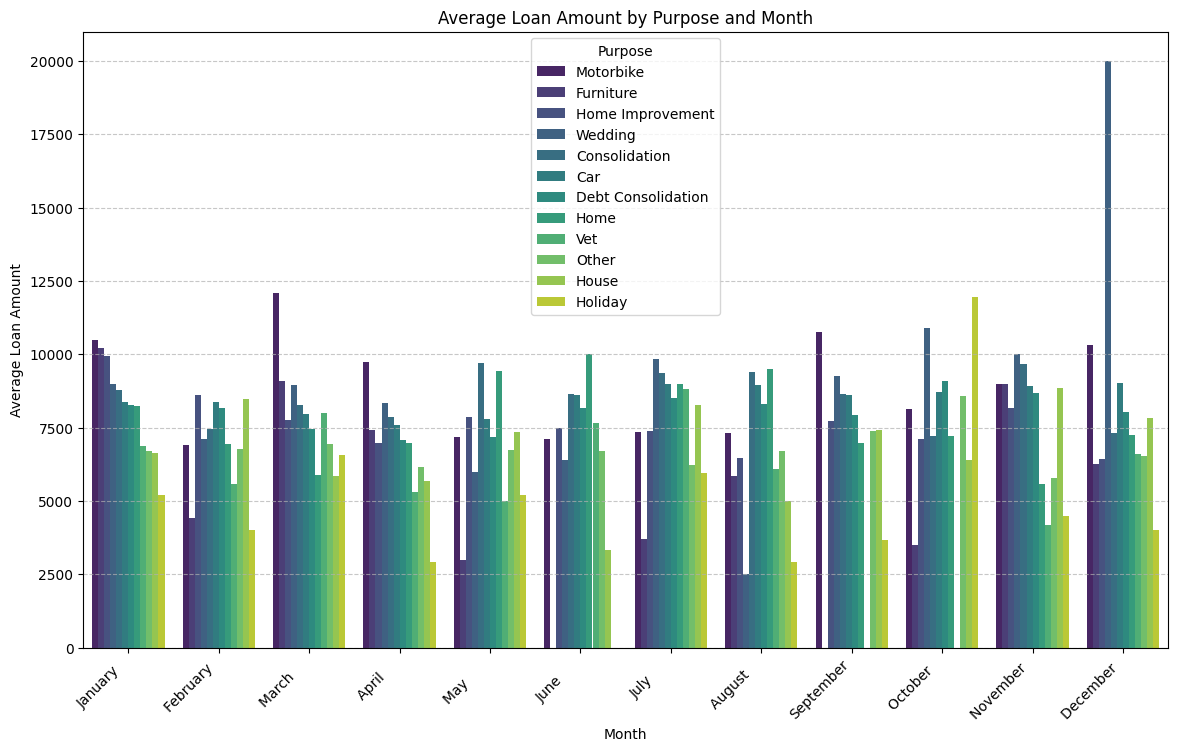

In [ ]:
plt.figure(figsize=(14, 8))
sns.barplot(
    x='application_month',
    y='avg_amount',
    hue='normalized_purpose',
    data=avg_load_by_purpose_and_month,
    palette='viridis'
)
plt.xlabel('Month')
plt.ylabel('Average Loan Amount')
plt.title('Average Loan Amount by Purpose and Month')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Purpose')
plt.grid(axis='y', linestyle='--', alpha=0.7)


The chart highlights several interesting trends:

Loans for "wedding" in December stand out significantly, with the average amount nearly twice as high as in other months, possibly due to a wedding season or higher expenses during this period.

Loans for "Motorbike" peak in March, potentially due to favorable weather conditions for purchasing a vehicle.

Loans with the purpose of "vet" are absent in September and October, while loans for "furniture" are missing in September, suggesting a seasonal drop in demand.

October shows a sharp increase in loans for "holiday," likely linked to vacation planning or festive events.

Categories like "Home Improvement" and "Car" exhibit relatively stable average values throughout the year, indicating consistent demand for these types of loans.

# Is there a correlation between the average age of the accounts and the loan amount?

In [ ]:
cor_between_avg_age_and_sum = pd.read_sql("""SELECT c."ALL_MeanAccountAge",
       l."Amount"
FROM l_apps AS l
JOIN credit_fs AS c ON l."UID" = c."UID";""", conn)


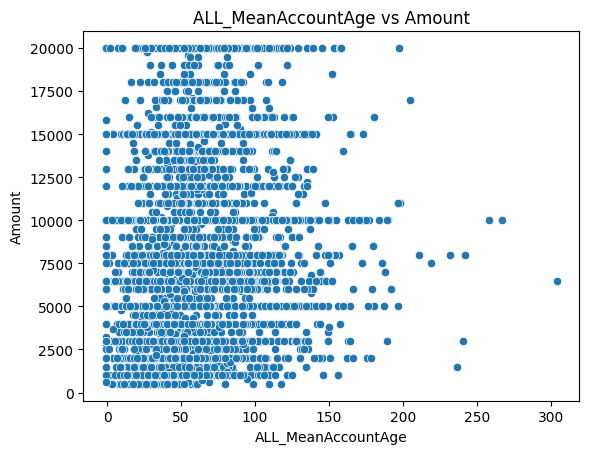

In [ ]:
sns.scatterplot(data=cor_between_avg_age_and_sum, x='ALL_MeanAccountAge', y='Amount')
plt.xlabel('ALL_MeanAccountAge')
plt.ylabel('Amount')
plt.title('ALL_MeanAccountAge vs Amount');

In [ ]:
correlation, _ = pearsonr(cor_between_avg_age_and_sum['ALL_MeanAccountAge'], cor_between_avg_age_and_sum['Amount'])
print(f'Correlation: {correlation}')

Correlation: 0.2050847723235225


The correlation coefficient is positive and weak 0.2. This means that there is a weak positive relationship between the average age of the accounts and the loan amount. However, this association is not very strong, indicating that other factors may have a greater impact on the loan amount.

# Is there a relationship between the number of accounts repaid and the loan term?

In [ ]:
relationship_between_settled_account_loan_term = pd.read_sql("""
SELECT c."ALL_CountSettled",
       l."Term"
FROM l_apps AS l
JOIN credit_fs AS c ON l."UID" = c."UID";""", conn)

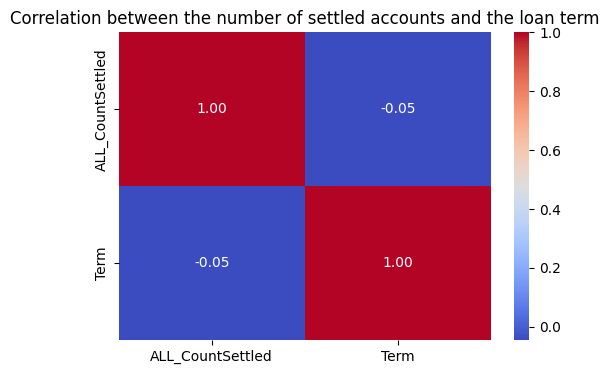

In [ ]:
correlation_matrix = relationship_between_settled_account_loan_term.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between the number of settled accounts and the loan term');

The -0.05 correlation between ALL_CountSettled (the number of accounts repaid) and Term (the term of the loan) means that there is a very weak negative correlation between these two variables. This suggests that there is no significant linear relationship between them - even if there are some cases where one variable increases, the other decreases, then this relationship is very weak.

# Additionally: I have made a table that compares the loan amounts and terms for customers who have the same loan purpose (LoanPurpose) and where both records are approved. But limited it, because this table has 16068 lines

In [ ]:
diff_among_term_with_same_purpose = pd.read_sql("""
SELECT a."LoanPurpose", a."UID", a."Amount", a."Term",
       b."UID" AS "Related_UID", b."Amount" AS "Related_Amount", b."Term" AS "Related_Term",
       ABS(a."Amount" - b."Amount") AS "Amount_Difference",
       ABS(a."Term" - b."Term") AS "Term_Difference"
FROM l_apps AS a
JOIN l_apps AS b ON a."LoanPurpose" = b."LoanPurpose"
WHERE a."UID" != b."UID"
  AND a."Success" = 1
  AND b."Success" = 1;""", conn)

display(diff_among_term_with_same_purpose.head(5),diff_among_term_with_same_purpose.tail(5))

,LoanPurpose,UID,Amount,Term,Related_UID,Related_Amount,Related_Term,Amount_Difference,Term_Difference
0,Buying new car,9111249,6000,48,6118819,6500,48,500,0
1,Buying new car,6118819,6500,48,9111249,6000,48,500,0
2,CAR,7139989,2000,24,3332173,6500,48,4500,24
3,CAR,7139989,2000,24,5574462,12000,60,10000,36
4,CAR,7139989,2000,24,5788220,6500,48,4500,24


,LoanPurpose,UID,Amount,Term,Related_UID,Related_Amount,Related_Term,Amount_Difference,Term_Difference
16063,vehicle purchase,6724618,6500,48,7879721,4000,24,2500,24
16064,vehicle purchase,4168272,6000,24,6724618,6500,48,500,24
16065,vehicle purchase,4168272,6000,24,7879721,4000,24,2000,0
16066,vehicle purchase,7879721,4000,24,6724618,6500,48,2500,24
16067,vehicle purchase,7879721,4000,24,4168272,6000,24,2000,0


**General Conclusion:**
The analysis revealed that 89.7% of loan applications were rejected. The most popular loan purposes are car purchases, housing, and debt consolidation.

**Ideal Candidate for Loan Approval:**

**Loan term:** 42 months.

**Long-term financial relationship** with the bank (over 15 years).

**Average number of open accounts** in the past year: 2.45.

**High average balance:** approximately 66,000.

**No overdue payments.**

These characteristics are key factors influencing the bank’s decision to approve applications. Banks can use this analysis to enhance the client evaluation process and improve financial products.

# Recommendations Based on the Project:

### Improve the Loan Approval Process:
Conduct a detailed analysis of the 89.7% rejected applications to identify the main reasons for denial.
Simplify requirements for specific loan purposes (e.g., home improvement or short-term loans) to expand the customer base.

### Develop Targeted Loan Offers:
Create specialized financial products for the most popular purposes, such as car purchases, debt consolidation, and housing loans.
Introduce flexible repayment plans tailored to customer segments with higher approval potential.

### Enhance Risk Assessment Models:
Focus on key factors like long-term relationships with the bank, a stable financial history, and minimal overdue payments to refine credit risk evaluation models.

### Increase Customer Retention and Engagement:
Encourage customers to maintain long-term relationships with the bank by offering loyalty programs or benefits for consistent account holders (e.g., reduced interest rates or exclusive loan products).

### Promote Financial Education:
Educate customers about maintaining a high credit score, reducing unnecessary debt, and managing accounts effectively to improve their chances of loan approval.

### Leverage Seasonality Trends:
Use insights about seasonal loan demand to design marketing campaigns and promotional offers during high-demand periods, such as January and December.

### Expand Credit Offerings for Underrepresented Categories:
Develop strategies to better accommodate loans with low approval rates (e.g., wedding, holiday, and veterinary loans) by reassessing criteria or introducing co-signing options.

By implementing these recommendations, the bank can optimize its loan approval process, improve customer satisfaction, and expand its market presence.